In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14494480343520806349
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1229225032833911937
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [3]:
master_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/HealthCare/worldometer_coronavirus_daily_data_latest.csv')
master_df.head()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
0,2020-2-15,Afghanistan,0.0,NaN,0.0,0.0,NaN
1,2020-2-16,Afghanistan,0.0,NaN,0.0,0.0,NaN
2,2020-2-17,Afghanistan,0.0,NaN,0.0,0.0,NaN
3,2020-2-18,Afghanistan,0.0,NaN,0.0,0.0,NaN
4,2020-2-19,Afghanistan,0.0,NaN,0.0,0.0,NaN


In [4]:
master_df.tail()

,date,country,cumulative_total_cases,daily_new_cases,active_cases,cumulative_total_deaths,daily_new_deaths
152730,2022-1-01,Zimbabwe,214214.0,956.0,26786.0,5017.0,13.0
152731,2022-1-02,Zimbabwe,214878.0,664.0,26585.0,5032.0,15.0
152732,2022-1-03,Zimbabwe,216087.0,1209.0,25446.0,5047.0,15.0
152733,2022-1-04,Zimbabwe,217678.0,1591.0,24620.0,5078.0,31.0
152734,2022-1-05,Zimbabwe,219057.0,1379.0,24252.0,5092.0,14.0


In [5]:
master_df.shape

(152735, 7)

In [6]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152735 entries, 0 to 152734
Data columns (total 7 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date                     152735 non-null  object 
 1   country                  152735 non-null  object 
 2   cumulative_total_cases   152735 non-null  float64
 3   daily_new_cases          145244 non-null  float64
 4   active_cases             147898 non-null  float64
 5   cumulative_total_deaths  145825 non-null  float64
 6   daily_new_deaths         129468 non-null  float64
dtypes: float64(5), object(2)
memory usage: 8.2+ MB


In [7]:
df = master_df[master_df['country'] == 'India']

In [8]:
df.fillna(0,inplace=True)

In [9]:
df.reset_index(drop=True,inplace=True)

In [10]:
df = df[df['daily_new_cases'] != 0]

In [11]:
df.reset_index(inplace=True,drop=True)

In [12]:
time = pd.date_range(start='3/2/2020',periods=674,freq='D')
df['time_stamp'] = pd.DataFrame(time)
df.drop(['date','country'],axis=1,inplace=True)
df = df.set_index('time_stamp')

In [13]:
df = df[['daily_new_cases']]

In [14]:
df.head()

,daily_new_cases
time_stamp,
2020-03-02,3.0
2020-03-03,1.0
2020-03-04,22.0
2020-03-05,1.0
2020-03-06,1.0


In [15]:
df.tail()

,daily_new_cases
time_stamp,
2021-12-31,27553.0
2022-01-01,33750.0
2022-01-02,37379.0
2022-01-03,58097.0
2022-01-04,90928.0


In [16]:
plt.rcParams['figure.figsize'] = [15,8]

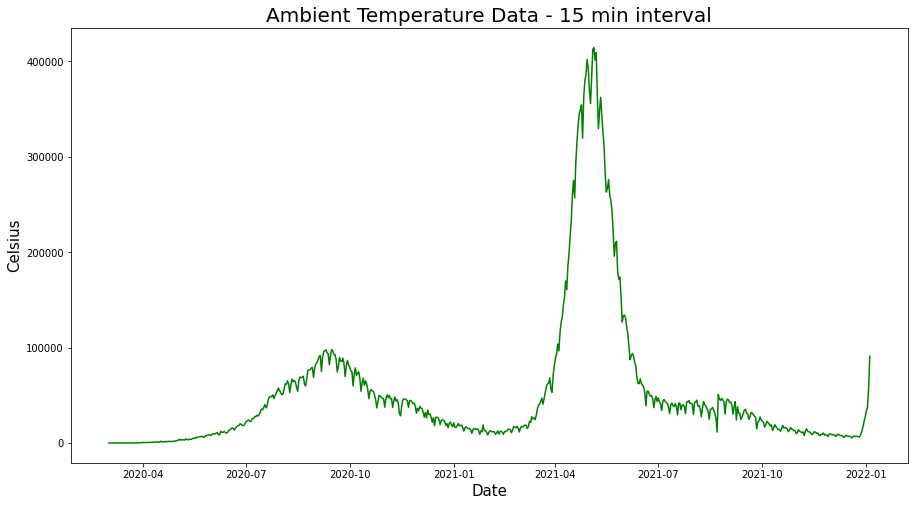

In [17]:
plt.plot(df,color='green')
plt.title('Ambient Temperature Data - 15 min interval',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Celsius',fontsize=15)
plt.show()

In [36]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [46]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['daily_new_cases'] = df['daily_new_cases'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [47]:
#Split data set into testing dataset and train dataset
train_size = 600
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 10
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [21]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(590, 1, 10)
(590,)
(64, 1, 10)
(64,)


In [22]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 27.7 MB/s 


In [23]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,SimpleRNN
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(LSTM(hp.Int('rnn_layer',min_value=4,max_value=96,step=4), activation="relu",input_shape=(1,look_back),recurrent_dropout = hp.Choice("first_recurrent_dropout",[0.2,0.4,0.6],default=0.2)))
    model.add(Dense(hp.Int('dense_layer',min_value=4,max_value=96,step=4),activation="relu"))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mape',
        metrics=['mape'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_mape',
    max_trials=10,
    executions_per_trial=1,
    directory='project',
    project_name='loa_em_1')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
rnn_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
first_recurrent_dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.4, 0.6], 'ordered': True}
dense_layer (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 96, 'step': 4, 'sampling': None}
Dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [ ]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=36,
             validation_data=(testX, testY))

Trial 10 Complete [00h 00m 24s]
val_mape: 3.2790133953094482

Best val_mape So Far: 3.2188055515289307
Total elapsed time: 00h 05m 07s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in project/loa_em_1
Showing 10 best trials
Objective(name='val_mape', direction='min')
Trial summary
Hyperparameters:
rnn_layer: 84
first_recurrent_dropout: 0.2
dense_layer: 32
Dropout_rate: 0.5
learning_rate: 0.006930815916903991
Score: 3.2188055515289307
Trial summary
Hyperparameters:
rnn_layer: 52
first_recurrent_dropout: 0.6
dense_layer: 96
Dropout_rate: 0.5
learning_rate: 0.0008445072115690769
Score: 3.224091053009033
Trial summary
Hyperparameters:
rnn_layer: 44
first_recurrent_dropout: 0.6
dense_layer: 12
Dropout_rate: 0.1
learning_rate: 0.03014307520134737
Score: 3.2790133953094482
Trial summary
Hyperparameters:
rnn_layer: 56
first_recurrent_dropout: 0.2
dense_layer: 12
Dropout_rate: 0.1
learning_rate: 0.023210424280584868
Score: 3.293785333633423
Trial summary
Hyperparameters:
rnn_layer: 4
first_recurrent_dropout: 0.6
dense_layer: 80
Dropout_rate: 0.2
learning_rate: 0.0009362649137761365
Score: 3.4861161708831787
Trial summary
Hyperparameters:
rnn_layer:

In [ ]:
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 10))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 84)                31920     
                                                                 
 dense (Dense)               (None, 32)                2720      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 34,673
Trainable params: 34,673
Non-trainable params: 0
_________________________________________________________________


In [24]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Bidirectional

In [48]:
model = Sequential()
model.add(Bidirectional(LSTM(512,activation='relu',input_dim = 10,return_sequences=True)))
model.add(Bidirectional(LSTM(256,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(128,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True)))
model.add(Bidirectional(LSTM(32,activation='relu')))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00005930815916903991)
model.compile(optimizer = ad, loss = 'mape', metrics = ['mape'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 36, epochs = 700)

Epoch 1/700
17/17 [==============================] - 16s 184ms/step - loss: 99.5966 - mape: 99.5966 - val_loss: 98.7414 - val_mape: 98.7414
Epoch 2/700
17/17 [==============================] - 2s 90ms/step - loss: 98.6504 - mape: 98.6504 - val_loss: 97.4119 - val_mape: 97.4119
Epoch 3/700
17/17 [==============================] - 2s 91ms/step - loss: 97.6582 - mape: 97.6582 - val_loss: 95.9847 - val_mape: 95.9847
Epoch 4/700
17/17 [==============================] - 2s 91ms/step - loss: 96.5699 - mape: 96.5699 - val_loss: 94.4365 - val_mape: 94.4365
Epoch 5/700
17/17 [==============================] - 2s 91ms/step - loss: 95.3427 - mape: 95.3427 - val_loss: 92.6372 - val_mape: 92.6372
Epoch 6/700
17/17 [==============================] - 2s 92ms/step - loss: 93.8261 - mape: 93.8261 - val_loss: 90.4194 - val_mape: 90.4194
Epoch 7/700
17/17 [==============================] - 2s 91ms/step - loss: 91.8011 - mape: 91.8011 - val_loss: 87.4238 - val_mape: 87.4238
Epoch 8/700
17/17 [=============

In [49]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [50]:
train_score = model.evaluate(trainX, trainY,verbose=0)
test_score = model.evaluate(testX, testY,verbose=0)

Train MAPE : 2.84 
Test MAPE : 3.06 


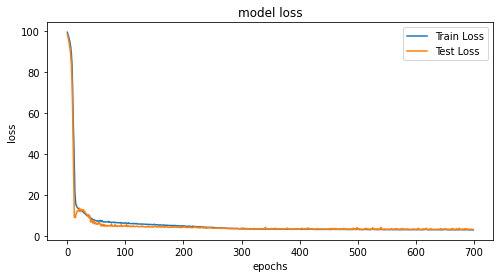

In [51]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print('Train MAPE : %.2f ' % (train_score[1]))
print('Test MAPE : %.2f ' % (test_score[1]))
model_loss(model_history)

In [31]:
import seaborn as sns

In [52]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(590,654)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

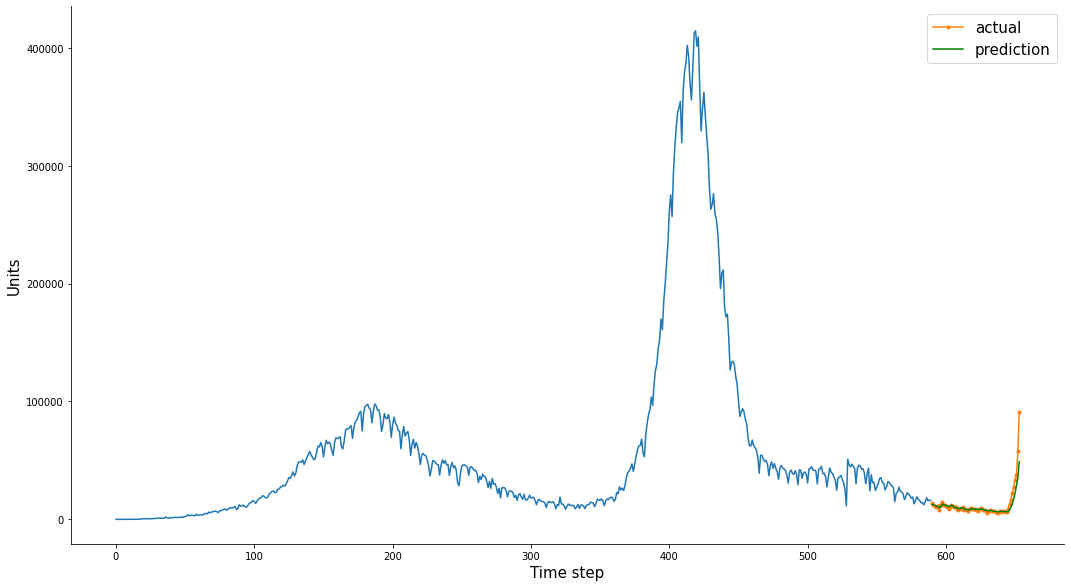

In [53]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)